<a href="https://colab.research.google.com/github/tolom131/Human-Activity-Recognition/blob/main/Tensorflow/supervised%20autoencoder_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Conv1D, Activation, MaxPooling1D, UpSampling1D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

import random
from resource import *
import time
import math
import sys
from collections import Counter

import random as rn
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/HAR/'
filename_data   = 'WISDM_at_v2.0_raw.txt'

import sys
sys.path.append('/content/drive/MyDrive/HAR/')
import wisdm_1_1
import wisdm_2_0
# x_train, y_train, num_classes = wisdm_1_1.create_wisdm_1_1(directory_data + filename_data)
origianl_x, original_y, num_classes = wisdm_2_0.create_wisdm_2_0(directory_data + filename_data)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


x_train.shape :  (14423, 200, 3) y_train.shape:  (14423, 6)


In [3]:
def create_supervised_autoencoder(x_train, y_train, x_val, y_val, alpha = 0.1):    
    #############################
    # setting methods
    #############################
    initializer = tf.keras.initializers.GlorotNormal()
    earlystop = EarlyStopping(patience=100, monitor='val_loss', mode='min')
    
    filepath = "SAE.h5"
    checkpoint = ModelCheckpoint(filepath, verbose = 0, mode="min", save_best_only=True, save_weights_only = True)
    callbacks_list = [checkpoint]
    
    def make_adam(rates = 0.0001):
        return keras.optimizers.Adam(learning_rate=rates)
    
    #############################
    # Autoencoder
    #############################
    inputs = Input(shape=(TIME_PERIODS, N_FEATURES))

    x = Conv1D(256, kernel_size=3, padding="same", kernel_initializer= initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(512, kernel_size=3, padding="same", kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    encoded = MaxPooling1D(2)(x)

    x = Conv1D(1024, kernel_size=3, padding="same", kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    encoded = MaxPooling1D(2)(x)

    x = Conv1D(1024, kernel_size=3, padding="same", kernel_initializer=initializer)(encoded)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    x = UpSampling1D(2)(x)

    x = Conv1D(512, kernel_size=3, padding="same", kernel_initializer= initializer)(encoded)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    x = UpSampling1D(2)(x)

    x = Conv1D(256, kernel_size=3, padding="same", kernel_initializer= initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    x = UpSampling1D(2)(x)

    decoded = Conv1D(3, kernel_size=3, activation="linear", padding="same", name="decoded", kernel_initializer= initializer)(x)
    encoder = Model(inputs, encoded)
    autoencoder = Model(inputs, decoded)
    
    #############################
    # Classifier
    #############################    
    adam = make_adam(0.01)

    _, dim0, dim1 = encoder.layers[-1].output_shape
    x = Conv1D(filters=64, kernel_size=3, input_shape=(dim0, dim1), kernel_initializer=initializer)(encoded)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv1D(filters=128, kernel_size=3, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = LSTM(128, kernel_initializer=initializer)(x)
    classified = Dense(num_classes, activation="softmax", name="classified", kernel_initializer=initializer)(x)
    
    #############################
    # Semi-Supervised Autoencoder
    #############################    
    print("\ntranining supervised autoencoder!")
    model = Model(inputs=[inputs], outputs=[classified, decoded])
    model.compile(optimizer=adam, loss=["categorical_crossentropy", "mse"], loss_weights=[alpha, 1-alpha], metrics=["accuracy"])
    history = model.fit([x_train], [y_train, x_train], validation_data = ([x_val], [y_val, x_val]), batch_size = 128, epochs=700, verbose=1, callbacks=callbacks_list)
    print("traning finished!")
    
    return history, model, filepath


In [4]:
# fix the random seed
# seed_sum = 42
# np.random.seed(seed_sum)
# rn.seed(seed_sum)
# tf.random.set_seed(seed_sum)

TIME_PERIODS = 200
STEP = 200
N_FEATURES = 3

# 80%, 10%, 10%로 set 나누기
x_train, x_val, y_train, y_val = train_test_split(origianl_x, original_y, test_size=0.2, stratify=original_y)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val)

history_train = []
history_val = []
history_test = []

history_train_loss = []
history_val_loss = []
history_test_loss = []

dr_rate = 0
print("===========================================================================")
# print("alpha : ", alpha)
#print("number of kernel : ", kernel)
history, model, filepath = create_supervised_autoencoder(x_train, y_train, x_val, y_val)
print("maximum train acc : ", max(history.history["classified_accuracy"]))
print("maximum valid acc : ", max(history.history["val_classified_accuracy"]))

model.load_weights(filepath)
test_results = model.evaluate([x_test], [y_test, x_test])
y_pred = model.predict([x_test])[0]
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("test acc : ", test_results[3])
print("test loss : ", test_results[0])

score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
print("f1 score : ", score)

print(matrix)
label = ["Jogging", "LyingDown", "Sitting", "Stairs", "Stading", "Walking"]
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation="nearest")
fig.colorbar(cax)
ax.set_xticklabels(['']+label)
ax.set_yticklabels(['']+label)
plt.show()

print("===========================================================================\n")



tranining supervised autoencoder!
Epoch 1/700
91/91 [==============================] - 15s 96ms/step - loss: 1.6962 - classified_loss: 1.1492 - decoded_loss: 1.7570 - classified_accuracy: 0.5648 - decoded_accuracy: 0.5678 - val_loss: 0.2668 - val_classified_loss: 1.4095 - val_decoded_loss: 0.1399 - val_classified_accuracy: 0.4820 - val_decoded_accuracy: 0.6735
Epoch 2/700
91/91 [==============================] - 7s 80ms/step - loss: 0.1276 - classified_loss: 0.9128 - decoded_loss: 0.0404 - classified_accuracy: 0.6606 - decoded_accuracy: 0.7336 - val_loss: 0.2681 - val_classified_loss: 2.2401 - val_decoded_loss: 0.0490 - val_classified_accuracy: 0.2490 - val_decoded_accuracy: 0.6722
Epoch 3/700
91/91 [==============================] - 7s 80ms/step - loss: 0.1230 - classified_loss: 0.8745 - decoded_loss: 0.0395 - classified_accuracy: 0.6791 - decoded_accuracy: 0.7247 - val_loss: 0.2151 - val_classified_loss: 1.5029 - val_decoded_loss: 0.0721 - val_classified_accuracy: 0.4563 - val_decod

NameError: ignored

46/46 [==============================] - 1s 12ms/step - loss: 0.0319 - classified_loss: 0.3005 - decoded_loss: 0.0021 - classified_accuracy: 0.8967 - decoded_accuracy: 0.8337
test acc :  0.8967428803443909
test loss :  0.03194761276245117
f1 score :  0.8542918118161741


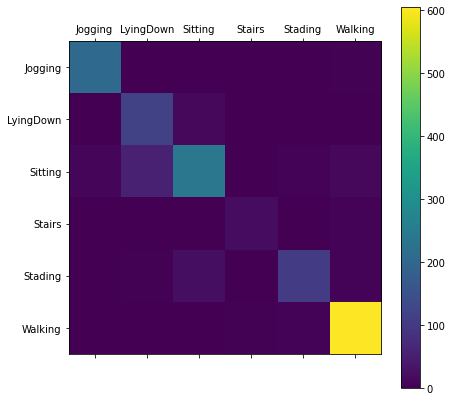

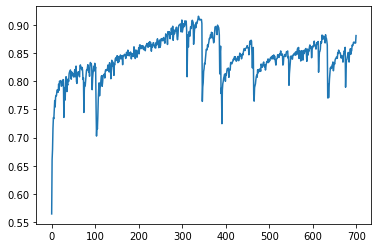

In [9]:
model.load_weights(filepath)
test_results = model.evaluate([x_test], [y_test, x_test])
y_pred = model.predict([x_test])[0]
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("test acc : ", test_results[3])
print("test loss : ", test_results[0])

score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
print("f1 score : ", score)

# print(matrix)
label = ["Jogging", "LyingDown", "Sitting", "Stairs", "Stading", "Walking"]
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation="nearest")
fig.colorbar(cax)
ax.set_xticklabels(['']+label)
ax.set_yticklabels(['']+label)
plt.show()

plt.plot(np.arange(700), history.history["classified_accuracy"])
plt.show()

CNN : 64 128 128 64

Classifier : 그대로

결과: 0.9119086265563965, 0.9162588119506836(두번 실행함)

CNN : 64 128 256 256 128 64

첫 번째 시도 : 0.8860793709754944 (earlystopping 100) 363 에포크 까지만 훈련 진행됨
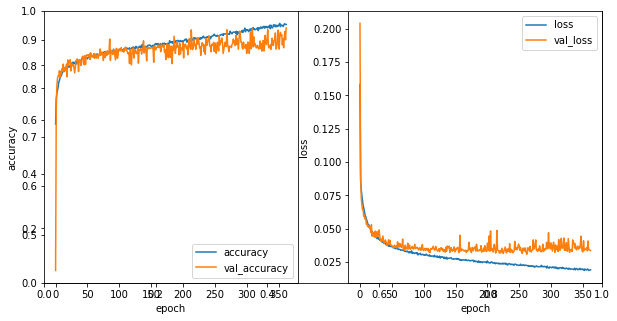

두 번째 시도 : 0.915986955165863 (earlystop 없음)

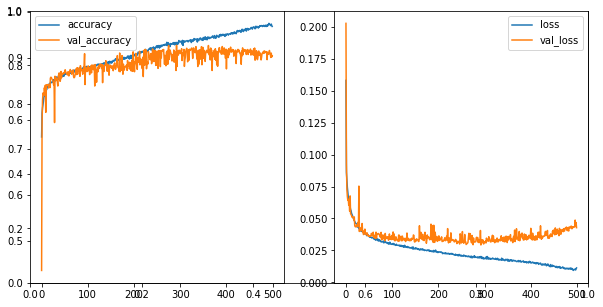


타입스텝 200으로 올렸을 때 결과 : 0.8690228462219238

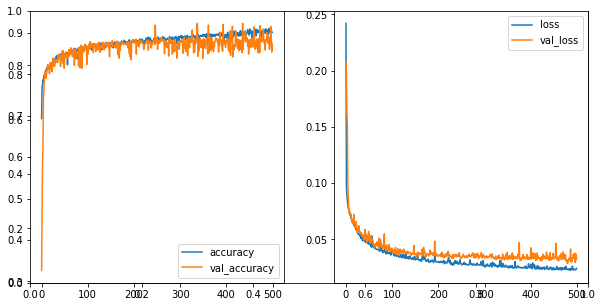



타입 스텝: 200, 스텝 : 200

커널 : 3개 / 32 64 128 128 64 32

classifier : CNN : 13 LSTM : 32

결과 : 0.8953568935394287

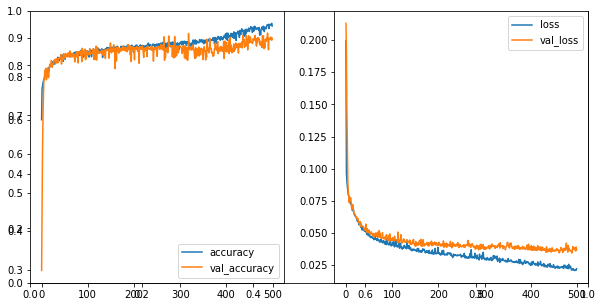